**Data prepertion : Police Press releases**

Opening file

In [48]:
import pandas as pd

df = pd.read_csv('../../../data/staging/audited data/combined_news_articles_final.csv')

# Filter to only keep rows where is_accident is True
df = df[df['is_accident'] == True]

print("First 5 rows (filtered for is_accident = True):")
print(df.head())
print(f"\nNumber of rows after filtering: {len(df)}")

First 5 rows (filtered for is_accident = True):
   article_id                                           og_title  \
0      4208.0  Driver stuck in traffic says speeding LESA car...   
1      4208.0  Driver stuck in traffic says speeding LESA car...   
3      4093.0  Motorcyclist seriously hurt in St Paul's Bay b...   
4      4110.0  Skip involved in horror St Paul’s Bay bypass c...   
5      4066.0  Two people, including teenage girl, critically...   

                                          og_content og_date_published  \
0  A motorist claims his car mirror was shattered...        2024-12-07   
1  A motorist claims his car mirror was shattered...        2024-12-07   
3  A motorcyclist was rushed to hospital in a cri...        2024-12-11   
4  A private contractor who placed a skip on St P...        2024-12-12   
5  A 29-year-old man and 17-year-old girl were cr...        2024-12-14   

                   og_created_at    accident_datetime  is_accident  \
0  2025-07-03 15:14:21.55413

Show basic statistics of individual accidents

In [49]:
print("Frequency of 'article_id' in the original DataFrame:")
print(df['article_id'].value_counts().sort_index())

Frequency of 'article_id' in the original DataFrame:
article_id
287.0       2
313.0       3
361.0       2
381.0       2
404.0       2
           ..
496158.0    4
496202.0    2
496206.0    2
496274.0    1
496362.0    4
Name: count, Length: 222, dtype: int64


In [50]:
max_frequency = df['article_id'].value_counts().max()
print(f"The maximum frequency of any 'article_id' is: {max_frequency}")

The maximum frequency of any 'article_id' is: 4


Transform rows in columns for identical accidents

In [51]:
# Define the static columns that should be unique per article_id
static_cols = [
    'article_id', 'og_title', 'og_content', 'og_date_published', 'accident_datetime', 'is_accident',
    'street', 'city'
]

# Define the dynamic columns that need to be expanded with prefixes
dynamic_cols = [
    'number_injured', 'accident_severity', 'vehicle_type',
    'driver_age', 'driver_gender'
]

# Extract unique static columns for each article_id
df_static_unique = df[static_cols].drop_duplicates(subset=['article_id']).set_index('article_id')

# Function to process dynamic columns for each group
def process_dynamic_group(group):
    row_data = {}
    # Using uppercase letters for prefixes A, B, C...
    prefixes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

    for i, (_, row) in enumerate(group[dynamic_cols].iterrows()):
        prefix = prefixes[i]
        for col in dynamic_cols:
            row_data[f'{prefix}_{col}'] = row[col]
    return pd.Series(row_data)

# Apply the function to each article_id group for dynamic columns
# Convert the resulting Series (with MultiIndex) to a DataFrame by unstacking
df_dynamic_processed = df.groupby('article_id').apply(process_dynamic_group, include_groups=False).unstack()

# Combine the static unique data with the processed dynamic data
df_combined = df_static_unique.merge(df_dynamic_processed, left_index=True, right_index=True, how='left')

# Reset index to make article_id a regular column again
df_combined = df_combined.reset_index()

# Display the first few rows of the combined DataFrame
print("Combined DataFrame head:")
print(df_combined.head())

# Display the number of rows in the new DataFrame
print(f"\nNumber of rows in the combined DataFrame: {len(df_combined)}")

Combined DataFrame head:
   article_id                                           og_title  \
0      4208.0  Driver stuck in traffic says speeding LESA car...   
1      4093.0  Motorcyclist seriously hurt in St Paul's Bay b...   
2      4110.0  Skip involved in horror St Paul’s Bay bypass c...   
3      4066.0  Two people, including teenage girl, critically...   
4      4066.5  Two people, including teenage girl, critically...   

                                          og_content og_date_published  \
0  A motorist claims his car mirror was shattered...        2024-12-07   
1  A motorcyclist was rushed to hospital in a cri...        2024-12-11   
2  A private contractor who placed a skip on St P...        2024-12-12   
3  A 29-year-old man and 17-year-old girl were cr...        2024-12-14   
4  A 29-year-old man and 17-year-old girl were cr...        2024-12-14   

     accident_datetime  is_accident                street           city  \
0  2024-12-04 17:00:00         True         R

In [52]:
print(df_combined[['article_id','A_vehicle_type','B_vehicle_type','C_vehicle_type']])

     article_id A_vehicle_type B_vehicle_type C_vehicle_type
0        4208.0            Car            Car            NaN
1        4093.0      Motorbike            NaN            NaN
2        4110.0      Motorbike            NaN            NaN
3        4066.0            Car     Pedestrian            NaN
4        4066.5     Pedestrian            Car            NaN
..          ...            ...            ...            ...
217    496158.0            car            car            car
218    496206.0            Car            Car            NaN
219    496202.0      Motorbike            Car            NaN
220    496274.0            car            NaN            NaN
221    496362.0            car      Motorbike            car

[222 rows x 4 columns]


Engineer feature related to incident date/time

In [53]:
from datetime import timedelta

# Add holiday/event/school indicators
def get_holiday_event_status(dt):
    """
    Determine if date is a holiday, event, or school holiday period.
    
    Returns: (is_holiday, is_event, is_school_holiday)
    """
    if pd.isna(dt):
        return 'no', 'no', 'no'
    
    date = dt.date() if hasattr(dt, 'date') else dt
    year = date.year
    month = date.month
    day = date.day
    
    # Maltese public holidays (fixed dates)
    # These are official public holidays that may affect traffic patterns due to
    # increased leisure travel, celebrations, and reduced commercial activity
    holidays = [
        (1, 1),   # New Year's Day
        (2, 10),  # St Paul's Shipwreck (Feast of St Paul's Shipwreck)
        (3, 19),  # St Joseph's Day
        (3, 31),  # Freedom Day (Jum il-Ħelsien)
        (5, 1),   # Workers' Day (May Day)
        (6, 7),   # Sette Giugno (Commemoration of 1919 riots)
        (6, 29),  # St Peter & St Paul (L-Imnarja - major feast)
        (8, 15),  # Assumption of Mary (Santa Marija - mid-summer holiday)
        (9, 8),   # Victory Day (Our Lady of Victories)
        (9, 21),  # Independence Day
        (12, 8),  # Immaculate Conception
        (12, 13), # Republic Day
        (12, 25), # Christmas Day
        (12, 26), # Boxing Day
    ]
    
    # Variable holidays for 2024-2025 (change yearly based on lunar calendar)
    # Good Friday and Easter Sunday dates vary each year
    variable_holidays = {
        2024: [(3, 29), (3, 30)],  # Good Friday, Easter Sunday 2024
        2025: [(4, 18), (4, 19)],  # Good Friday, Easter Sunday 2025
    }
    
    # School holidays periods (approximate)
    # School holidays may affect traffic patterns due to families traveling,
    # reduced rush-hour congestion, and increased daytime leisure traffic
    # Returns 'yes' if accident occurred during school holidays, 'no' otherwise
    school_holidays = [
        ('summer', 6, 20, 9, 15),    # Summer break: June 20 - Sept 15 (longest holiday)
        ('christmas', 12, 20, 1, 7), # Christmas break: Dec 20 - Jan 7 (crosses year boundary)
        ('easter', 4, 10, 4, 20),    # Easter break: April 10-20 (approx, varies with Easter date)
    ]
    
    # Notable events that affect traffic patterns (festa season, carnival, etc.)
    # These events involve road closures, processions, increased pedestrian traffic,
    # and visitors traveling to/from villages. Returns 'yes' during event periods
    events = {
        2024: [
            (2, 10, 2, 13),  # Carnival 2024 (weekend of celebrations, street parties)
            (6, 1, 9, 30),   # Festa season: June-Sept (village feasts throughout Malta)
        ],
        2025: [
            (3, 1, 3, 4),    # Carnival 2025 (weekend of celebrations, street parties)
            (6, 1, 9, 30),   # Festa season: June-Sept (village feasts throughout Malta)
        ]
    }
    
    is_holiday = 'no'
    is_event = 'no'
    is_school = 'no'
    
    # Check if it's a public holiday
    # Priority: 'eve of' overrides 'yes' if accident is day before a holiday
    if (month, day) in holidays:
        is_holiday = 'yes'
    elif year in variable_holidays and (month, day) in variable_holidays[year]:
        is_holiday = 'yes'
    
    # Check if it's eve of a holiday (day before)
    # Eve of holidays often have increased social activity and traffic
    next_day = date + timedelta(days=1)
    if (next_day.month, next_day.day) in holidays:
        is_holiday = 'eve of'
    elif year in variable_holidays and (next_day.month, next_day.day) in variable_holidays[year]:
        is_holiday = 'eve of'
    
    # Check if during event period
    if year in events:
        for event_start_m, event_start_d, event_end_m, event_end_d in events[year]:
            event_start = date.replace(month=event_start_m, day=event_start_d)
            event_end = date.replace(month=event_end_m, day=event_end_d)
            if event_start <= date <= event_end:
                is_event = 'yes'
                break
    
    # Check if during school holidays
    for holiday_name, start_m, start_d, end_m, end_d in school_holidays:
        try:
            if start_m <= end_m:  # Same year period
                start_date = date.replace(month=start_m, day=start_d)
                end_date = date.replace(month=end_m, day=end_d)
                if start_date <= date <= end_date:
                    is_school = 'yes'
                    break
            else:  # Crosses year boundary (e.g., Christmas)
                start_date = date.replace(month=start_m, day=start_d)
                end_date = date.replace(year=date.year+1 if date.month < 6 else date.year, month=end_m, day=end_d)
                if date >= start_date or date <= end_date:
                    is_school = 'yes'
                    break
        except:
            pass
    
    return is_holiday, is_event, is_school

# Convert accident_datetime to datetime if it's not already
df_combined['accident_datetime'] = pd.to_datetime(df_combined['accident_datetime'])

# Apply the holiday detection function to df_combined
df_combined[['is_holiday', 'is_event', 'is_school_holiday']] = df_combined['accident_datetime'].apply(
    lambda dt: pd.Series(get_holiday_event_status(dt))
)

# Add weekend flag (Saturday=5, Sunday=6 in weekday())
df_combined['is_weekend'] = df_combined['accident_datetime'].apply(
    lambda dt: 'yes' if pd.notna(dt) and dt.weekday() in [5, 6] else 'no'
)

print("Holiday/Event/School/Weekend features added to df_combined:")
print(df_combined[['accident_datetime', 'is_holiday', 'is_event', 'is_school_holiday', 'is_weekend']].head(10))
print("\nValue counts for is_holiday:", df_combined['is_holiday'].value_counts())
print("\nValue counts for is_event:", df_combined['is_event'].value_counts())
print("\nValue counts for is_school_holiday:", df_combined['is_school_holiday'].value_counts())
print("\nValue counts for is_weekend:", df_combined['is_weekend'].value_counts())

Holiday/Event/School/Weekend features added to df_combined:
    accident_datetime is_holiday is_event is_school_holiday is_weekend
0 2024-12-04 17:00:00         no       no                no         no
1 2024-12-11 17:00:00         no       no                no         no
2 2024-12-11 17:00:00         no       no                no         no
3 2024-12-13 17:30:00        yes       no                no         no
4 2024-12-13 19:45:00        yes       no                no         no
5 2024-12-11 17:00:00         no       no                no         no
6 2024-12-11 17:00:00         no       no                no         no
7 2024-12-15 20:30:00         no       no                no        yes
8 2024-12-13 19:45:00        yes       no                no         no
9 2024-12-11 17:00:00         no       no                no         no

Value counts for is_holiday: is_holiday
no        199
eve of     15
yes         8
Name: count, dtype: int64

Value counts for is_event: is_event
no     115
ye

# **Coding time of accident -->**
   - early morning: - 06:01 to 08:00
   - morning        - 08:01 to 12:00
   - afternoon:     - 12:01 to 18:00
   - evening:       - 18:01 to 21:00
   - late evening:  - 21:01 to 23:00
   - Night:         - 23:01 to 06:00

In [54]:
# Extract the hour from 'accident_datetime'
# Convert accident_datetime to datetime if it's not already
df_combined['accident_datetime'] = pd.to_datetime(df_combined['accident_datetime'])

# Define a function to categorize the time of day

def categorize_time(row):
    hour = row['accident_datetime'].hour
    minute = row['accident_datetime'].minute

    # Convert time to minutes for easier comparison
    time_in_minutes = hour * 60 + minute

    if 361 <= time_in_minutes <= 480: # 06:01 (361) to 08:00 (480)
        return 'early morning'
    elif 481 <= time_in_minutes <= 720: # 08:01 (481) to 12:00 (720)
        return 'morning'
    elif 721 <= time_in_minutes <= 1080: # 12:01 (721) to 18:00 (1080)
        return 'afternoon'
    elif 1081 <= time_in_minutes <= 1260: # 18:01 (1081) to 21:00 (1260)
        return 'evening'
    elif 1261 <= time_in_minutes <= 1380: # 21:01 (1261) to 23:00 (1380)
        return 'late evening'
    else: # 23:01 (1381) to 06:00 (360)
        return 'Night'

# Apply the function to create the new 'accident_time_category' column
df_combined['accident_time_category'] = df_combined.apply(categorize_time, axis=1)

print("New 'accident_time_category' column added:")
print(df_combined[['accident_datetime', 'accident_time_category']].head())

print("\nValue counts for accident_time_category:")
print(df_combined['accident_time_category'].value_counts())


New 'accident_time_category' column added:
    accident_datetime accident_time_category
0 2024-12-04 17:00:00              afternoon
1 2024-12-11 17:00:00              afternoon
2 2024-12-11 17:00:00              afternoon
3 2024-12-13 17:30:00              afternoon
4 2024-12-13 19:45:00                evening

Value counts for accident_time_category:
accident_time_category
afternoon        73
Night            58
morning          33
early morning    24
evening          22
late evening     12
Name: count, dtype: int64


# **Capture unique severity level for each incident**

Categories level (lowest to highest) -->
1. unknown
2. not injured
3. slight
4. Grievious
5. Serious
6. Fatal


In [55]:
# Define the ranking of severity levels
severity_ranking = {
    'unknown': 1,
    'not injured': 2,
    'slight': 3,
    'Grievious': 4,
    'Serious': 5,
    'Fatal': 6
}

# Create a reverse mapping for displaying the final severity
reverse_severity_ranking = {v: k for k, v in severity_ranking.items()}

# List of columns to check for accident severity (excluding the original 'accident_severity')
severity_cols_to_check = [
    'A_accident_severity',
    'B_accident_severity',
    'C_accident_severity',
    'D_accident_severity'
]

# Function to determine the highest severity
def get_highest_severity(row):
    current_severities = []
    for col in severity_cols_to_check:
        # Get the severity string, defaulting to 'unknown' if NaN
        severity_str = row[col] if pd.notna(row[col]) else 'unknown'
        current_severities.append(severity_ranking.get(severity_str, 1)) # Default to 1 (unknown) if not in mapping

    # Find the maximum numerical severity and convert it back to string
    max_severity_rank = max(current_severities)
    return reverse_severity_ranking.get(max_severity_rank, 'unknown')

# Check if df_combined exists before proceeding
if 'df_combined' not in locals() and 'df_combined' not in globals():
    raise NameError("DataFrame 'df_combined' is not defined. Please ensure the preceding cell (cell id: cVkvsWAldAAl) that creates 'df_combined' has been executed.")

# Apply the function to create the new 'severity' column
df_combined['severity'] = df_combined.apply(get_highest_severity, axis=1)

print("First 5 rows with the new 'severity' column:")
print(df_combined[['article_id'] + severity_cols_to_check + ['severity']].head())

print("\nValue counts for the new 'severity' column:")
print(df_combined['severity'].value_counts())

First 5 rows with the new 'severity' column:
   article_id A_accident_severity B_accident_severity C_accident_severity  \
0      4208.0         not injured         not injured                 NaN   
1      4093.0             Serious                 NaN                 NaN   
2      4110.0             Serious                 NaN                 NaN   
3      4066.0         not injured             Serious                 NaN   
4      4066.5             Serious         not injured                 NaN   

  D_accident_severity     severity  
0                 NaN  not injured  
1                 NaN      Serious  
2                 NaN      Serious  
3                 NaN      Serious  
4                 NaN      Serious  

Value counts for the new 'severity' column:
severity
Serious        83
Fatal          56
Grievious      48
not injured    25
unknown         7
slight          3
Name: count, dtype: int64


In [56]:
# Calculate total number of injured across all vehicles
# List of columns to check for number_injured
injured_cols = ['A_number_injured', 'B_number_injured', 'C_number_injured', 'D_number_injured']

# Function to calculate total injured
def calculate_total_injured(row):
    total = 0
    for col in injured_cols:
        if col in row.index and pd.notna(row[col]):
            # Convert to numeric, handling any string values
            try:
                total += float(row[col])
            except (ValueError, TypeError):
                pass
    return total

# Apply the function to create the new 'total_injured' column
df_combined['total_injured'] = df_combined.apply(calculate_total_injured, axis=1)

print("Total injured column added:")
print(df_combined[['article_id'] + [col for col in injured_cols if col in df_combined.columns] + ['total_injured']].head(10))

print("\nBasic statistics for total_injured:")
print(df_combined['total_injured'].describe())

print("\nValue counts for total_injured:")
print(df_combined['total_injured'].value_counts().sort_index())

Total injured column added:
   article_id A_number_injured B_number_injured C_number_injured  \
0      4208.0                0                0              NaN   
1      4093.0                1              NaN              NaN   
2      4110.0                1              NaN              NaN   
3      4066.0                0                1              NaN   
4      4066.5                1                0              NaN   
5      4067.0                1              NaN              NaN   
6      4087.0                1              NaN              NaN   
7      4049.0                0                1              NaN   
8      4034.0                1                0              NaN   
9      4007.0                1              NaN              NaN   

  D_number_injured  total_injured  
0              NaN            0.0  
1              NaN            1.0  
2              NaN            1.0  
3              NaN            1.0  
4              NaN            1.0  
5      

In [57]:
# Save the combined dataframe to a CSV file
df_combined.to_csv('../../../data/staging/feature engineering/news_articles_final.csv', index=False)

print("Progress saved successfully!")
print(f"Number of rows saved: {len(df_combined)}")
print(f"Number of columns saved: {len(df_combined.columns)}")

Progress saved successfully!
Number of rows saved: 222
Number of columns saved: 35


# **One-hot code cities**

Step 1: show basic stats

Step 2: reduce to ~40 cities

Step 3: one-hot coding

Basic statistics for 'city' column:
city
Marsa            12
Naxxar           10
Birkirkara       10
St Paul's Bay    10
none              8
Rabat             7
Sliema            7
Floriana          7
Pembroke          5
Paola             5
Name: count, dtype: int64

Number of unique cities: 71
Total number of incidents: 222

Pareto data (Top 10 cities):
               counts  percentage  cumulative_percentage
city                                                    
Marsa              12    5.405405               5.405405
Naxxar             10    4.504505               9.909910
Birkirkara         10    4.504505              14.414414
St Paul's Bay      10    4.504505              18.918919
none                8    3.603604              22.522523
Rabat               7    3.153153              25.675676
Sliema              7    3.153153              28.828829
Floriana            7    3.153153              31.981982
Pembroke            5    2.252252              34.234234
Paola           

C:\Users\iscu02\AppData\Local\Temp\ipykernel_39324\2311638834.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pareto_data.index, rotation=90, ha='right')


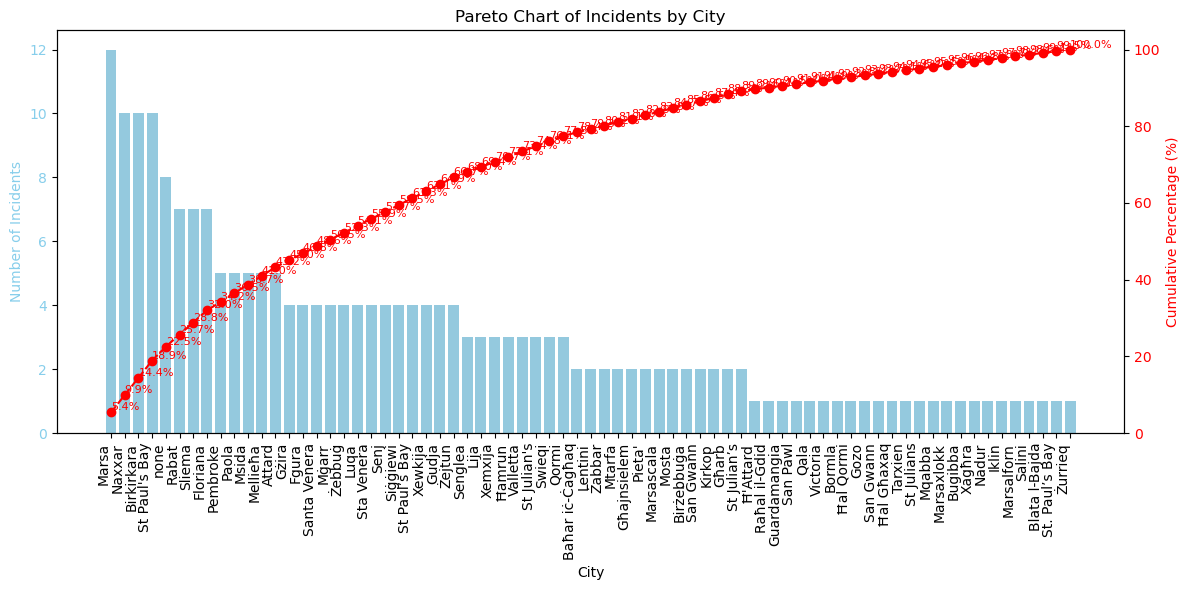

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Display basic statistics of 'city' ---
print("Basic statistics for 'city' column:")
city_counts = df_combined['city'].value_counts()
print(city_counts.head(10)) # Display top 10 most frequent cities
print(f"\nNumber of unique cities: {df_combined['city'].nunique()}")
print(f"Total number of incidents: {len(df_combined)}")

# --- Step 2: Prepare data for Pareto chart ---
# Calculate percentages and cumulative percentages
pareto_data = pd.DataFrame({
    'counts': city_counts,
    'percentage': city_counts / len(df_combined) * 100
})
pareto_data['cumulative_percentage'] = pareto_data['percentage'].cumsum()

print("\nPareto data (Top 10 cities):")
print(pareto_data.head(10))

# --- Step 3: Plot Pareto graph ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for city counts
sns.barplot(x=pareto_data.index, y='counts', data=pareto_data, ax=ax1, color='skyblue')
ax1.set_xlabel('City')
ax1.set_ylabel('Number of Incidents', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Pareto Chart of Incidents by City')
ax1.set_xticklabels(pareto_data.index, rotation=90, ha='right')

# Create a second y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(pareto_data.index, pareto_data['cumulative_percentage'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105) # Set y-axis limits for percentage

# Add cumulative percentage labels on the line
for x, y in zip(pareto_data.index, pareto_data['cumulative_percentage']):
    ax2.text(x, y, f'{y:.1f}%', color='red', ha='left', va='bottom', fontsize=8)

fig.tight_layout()
plt.show()


In [59]:
# Replace 'Ħaż-Żabbar' with 'Zabbar' in the 'city' column
df_combined['city'] = df_combined['city'].replace('Ħaż-Żabbar', 'Zabbar')

print("Updated value counts for 'city' column after replacement:")
print(df_combined['city'].value_counts().head(50))

print(f"\nNumber of unique cities after replacement: {df_combined['city'].nunique()}")

Updated value counts for 'city' column after replacement:
city
Marsa              12
Naxxar             10
Birkirkara         10
St Paul's Bay      10
none                8
Rabat               7
Sliema              7
Floriana            7
Pembroke            5
Paola               5
Msida               5
Mellieħa            5
Attard              5
Gżira               4
Fgura               4
Santa Venera        4
Mġarr               4
Żebbuġ              4
Luqa                4
Sta Venera          4
Senj                4
Siġġiewi            4
St Paul’s Bay       4
Xewkija             4
Gudja               4
Żejtun              4
Senglea             3
Lija                3
Xemxija             3
Ħamrun              3
Valletta            3
St Julian's         3
Swieqi              3
Qormi               3
Baħar iċ-Ċagħaq     2
Lentini             2
Żabbar              2
Mtarfa              2
Għajnsielem         2
Pieta'              2
Marsascala          2
Mosta               2
Birżebbuġa   

In [60]:
# Step 2: Reduce 'city' column to 45 categories

num_top_cities = 45
top_cities = df_combined['city'].value_counts().nlargest(num_top_cities).index

# Create a new column 'city_reduced'
# Replace cities not in top_cities with 'Other'
df_combined['city_reduced'] = df_combined['city'].apply(lambda x: x if x in top_cities else 'Other')

print(f"Number of unique cities after reduction: {df_combined['city_reduced'].nunique()}")
print("Value counts of 'city_reduced' after reduction:")
print(df_combined['city_reduced'].value_counts())

# Step 3: One-hot encode the 'city_reduced' column
city_one_hot = pd.get_dummies(df_combined['city_reduced'], prefix='city', dtype=int)

# Merge the one-hot encoded DataFrame with the original df_combined
df_combined = pd.concat([df_combined, city_one_hot], axis=1)

print("\nFirst 5 rows of df_combined with new one-hot encoded city columns:")
print(df_combined.head())

print(f"\nNew number of columns in df_combined: {len(df_combined.columns)}")

Number of unique cities after reduction: 46
Value counts of 'city_reduced' after reduction:
city_reduced
Other              28
Marsa              12
Birkirkara         10
St Paul's Bay      10
Naxxar             10
none                8
Floriana            7
Rabat               7
Sliema              7
Pembroke            5
Msida               5
Attard              5
Paola               5
Mellieħa            5
Gżira               4
Luqa                4
Mġarr               4
Senj                4
Żejtun              4
Fgura               4
Santa Venera        4
Sta Venera          4
Siġġiewi            4
St Paul’s Bay       4
Xewkija             4
Gudja               4
Żebbuġ              4
Senglea             3
Valletta            3
Lija                3
Xemxija             3
St Julian's         3
Ħamrun              3
Qormi               3
Swieqi              3
Mosta               2
Birżebbuġa          2
Għajnsielem         2
Marsascala          2
Pieta'              2
San Ġwann      

# ***Progress so far !!***

In [63]:
print("\n--- List of Column Headers in df_combined ---")
print(df_combined.columns.tolist())

print("\n--- Summary Info for df_combined ---")
df_combined.info()

print("\n--- Descriptive Statistics for df_combined (all columns) ---")
print(df_combined.describe(include='all'))


--- List of Column Headers in df_combined ---
['article_id', 'og_title', 'og_content', 'og_date_published', 'accident_datetime', 'is_accident', 'street', 'city', 'A_accident_severity', 'A_driver_age', 'A_driver_gender', 'A_number_injured', 'A_vehicle_type', 'B_accident_severity', 'B_driver_age', 'B_driver_gender', 'B_number_injured', 'B_vehicle_type', 'C_accident_severity', 'C_driver_age', 'C_driver_gender', 'C_number_injured', 'C_vehicle_type', 'D_accident_severity', 'D_driver_age', 'D_driver_gender', 'D_number_injured', 'D_vehicle_type', 'is_holiday', 'is_event', 'is_school_holiday', 'is_weekend', 'accident_time_category', 'severity', 'total_injured', 'city_reduced', 'city_Attard', 'city_Baħar iċ-Ċagħaq', 'city_Birkirkara', 'city_Birżebbuġa', 'city_Fgura', 'city_Floriana', 'city_Gudja', 'city_Għajnsielem', 'city_Gżira', 'city_Kirkop', 'city_Lentini', 'city_Lija', 'city_Luqa', 'city_Marsa', 'city_Marsascala', 'city_Mellieħa', 'city_Mosta', 'city_Msida', 'city_Mtarfa', 'city_Mġarr', '

# Duplicate Article Detection and Flagging

This section identifies potential duplicate articles in the combined news dataset by comparing key fields (regxdt_accident_datetime, llm_street, llm_city, and llm__vehicle_type) after normalizing them for case and whitespace. For each unique combination of these fields, only the second and subsequent unique article_id entries are flagged as potential duplicates. This ensures that only distinct articles (not multiple rows from the same article) are considered duplicates, and provides a list of previously seen article_ids for each flagged row to assist with manual review.

In [64]:
# Check for potential duplicate articles in news_articles_final.csv
import pandas as pd

combined_path = '../../../data/staging/feature engineering/news_articles_final.csv'
df_combined = pd.read_csv(combined_path)

# Normalize columns for duplicate detection (case-insensitive, remove whitespace)
dup_cols = ['accident_datetime', 'street', 'city']
for col in dup_cols:
    if col in df_combined.columns:
        df_combined[col + '_norm'] = (
            df_combined[col]
            .astype(str)
            .str.lower()
            .str.replace(r'\s+', '', regex=True)
            .str.strip()
        )
    else:
        df_combined[col + '_norm'] = ''

norm_cols = [col + '_norm' for col in dup_cols]

# For each row, flag only the second and subsequent articles (by article_id) with the same normalized keys
if 'article_id' in df_combined.columns:
    # Sort by normalized keys and article_id to ensure consistent ordering
    df_combined = df_combined.sort_values(norm_cols + ['article_id'])
    # For each group of normalized keys, flag only the second and subsequent unique article_ids
    def flag_second_and_later(group):
        seen = set()
        flags = []
        for aid in group['article_id']:
            if aid in seen:
                flags.append(False)
            elif len(seen) == 0:
                flags.append(False)
                seen.add(aid)
            else:
                flags.append(True)
                seen.add(aid)
        return pd.Series(flags, index=group.index)
    df_combined['potential_duplicate_article_id'] = (
        df_combined.groupby(norm_cols, group_keys=False).apply(flag_second_and_later)
    )
    # For reporting, also show which article_ids are already present for the flagged row
    def get_previous_ids(group):
        seen = []
        prev_ids = []
        for aid in group['article_id']:
            prev_ids.append(list(seen) if seen else None)
            if aid not in seen:
                seen.append(aid)
        return pd.Series(prev_ids, index=group.index)
    df_combined['previous_duplicate_article_ids'] = (
        df_combined.groupby(norm_cols, group_keys=False).apply(get_previous_ids)
    )
else:
    df_combined['potential_duplicate_article_id'] = False
    df_combined['previous_duplicate_article_ids'] = None

# Show flagged duplicates for review
duplicates = df_combined[df_combined['potential_duplicate_article_id']]
print(f"Potential duplicates found: {len(duplicates)}")
if not duplicates.empty:
    display_cols = (
        ['article_id', 'previous_duplicate_article_ids'] + dup_cols + ['title', 'source']
        if 'title' in df_combined.columns and 'source' in df_combined.columns
        else ['article_id', 'previous_duplicate_article_ids'] + dup_cols
    )
    display(duplicates[display_cols].sort_values(dup_cols))

# Optionally, save flagged duplicates for manual review
duplicates.to_csv('../../../data/staging/feature engineering/potential_duplicate_articles_flagged.csv', index=False)
print('✓ Flagged duplicates saved to potential_duplicate_articles_flagged.csv')

Potential duplicates found: 31


C:\Users\iscu02\AppData\Local\Temp\ipykernel_39324\1484274552.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined.groupby(norm_cols, group_keys=False).apply(flag_second_and_later)
C:\Users\iscu02\AppData\Local\Temp\ipykernel_39324\1484274552.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined.groupby(norm_cols, group_keys=False).apply(get_previous_ids)


,article_id,previous_duplicate_article_ids,accident_datetime,street,city
22,3861.0,[3653.0],2022-09-24 00:00:00,Triq il-Madliena,Swieqi
37,3588.0,[3558.0],2023-10-22 22:00:00,Regional Road,St Julian's
1,4093.0,[4087.0],2024-12-11 17:00:00,St Paul's Bay bypass,St Paul's Bay
2,4110.0,[4067.0],2024-12-11 17:00:00,St Paul’s Bay bypass,St Paul's Bay
10,4024.0,[2975.0],2024-12-11 17:00:00,St Paul’s Bay bypass,St Paul’s Bay
4,4066.5,[4034.0],2024-12-13 19:45:00,Dawret il-Gudja,Gudja
17,3966.0,[3704.0],2024-12-22 10:15:00,Triq Sir Philip Pullicino,Mtarfa
18,3938.0,[3910.0],2024-12-23 10:30:00,Regional Road,none
27,3740.0,[3699.0],2025-01-06 21:00:00,Mdina Road,Attard
25,3747.0,"[3699.0, 3740.0]",2025-01-06 21:00:00,Mdina road,Attard


✓ Flagged duplicates saved to potential_duplicate_articles_flagged.csv
